# Implements a CNN that processes weak lensing outputs

In [ ]:
# extract tarfiles if necessary and set specs for run

In [ ]:

import tarfile
import os
import shutil
from astropy.io import fits
import numpy as np
from scipy.ndimage import zoom
import re
import tensorflow as tf
import random



use_COLAB = 1

if use_COLAB == 1:
  #mount drive
  from google.colab import drive
  drive.mount('/content/gdrive')

  WORK_AREA = '/content/gdrive/My Drive/weaklensing_ML/' #columbialensing/
  os.chdir(WORK_AREA)

  #get GPU info
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)

# Specify the directory containing the .tar files
directory_path = 'columbialensing/'



max_cosmologies = -1 #for testing.  Set to -1 to use everything.
max_examples = 300 #examples in a cosmology, should divide by number_batches
number_batches = 10
validation_split = 0.4  # use this fraction of the data for validation
normalize_by_RMS = True #set to one if you want to renormalize by RMS
#number_examples = max_examples*(1+validation_split)

# Set the learning rate
learning_rate = 0.005

# image_size
image_size = 128
number_fits_files = 512
suffix = f"_{image_size}"
extract_tarfiles = False  #if I need to extract tarfiles

run_suffix = rf"im{image_size}_ex{max_examples}"
if max_cosmologies >0:
    run_suffix = run_suffix + f"mc{max_cosmologies}"

#extracts only if indicated (could make this more elegant by checking to see if they exist)
if extract_tarfiles:
    # Use a regular expression to match .tar files with the desired suffix
    pattern = re.compile(rf"{suffix}.tar$")

    # List all matching .tar files in the directory
    all_tar_files = [f for f in os.listdir(directory_path) if pattern.search(f)]

    # Extract the tar archive
    for tar_file in all_tar_files:
        #print(tar_file)
        tar_file_path = os.path.join(directory_path, tar_file)
        with tarfile.open(tar_file_path, 'r') as archive:
            archive.extractall(path=directory_path)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Tue Nov 14 19:13:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    52W / 400W |  17709MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----

# Map noise parameters

using that $$\sigma_{pix} = \sigma_e/\sqrt{2 n_g A_{\rm pix}}$$ where $\sigma_e$ is the mean intrinsic ellipciticy of galaxies ($\approx 0.4$) and $n_g$ number density of galaxies and $A_{\rm pix}$ is the area of a pixel.

In [ ]:
include_noise = False #flag to add noise with below parameters
include_smoothing = False  #flag to smooth with a gaussian with standard deviation theta_sm_arcmin, or in pixels, theta_smooth

theta_sm_arcmin = 1 #smoothing sd in arcmin
sigma_e = 0.4 #galaxy shape noise
n_g_perarcminsq = 30  #galaxies per arcmin
theta_map = 3.5 #degree (size of region)
Ag = (theta_map*60/image_size)**2 #in arc-min^2, using
theta_smooth = theta_sm_arcmin/(np.sqrt(Ag))

sigma_pix = sigma_e/np.sqrt(2*n_g_perarcminsq)

#model suffix
if include_noise:
    noise_suffix = f'_s{sigma_e:0.1f}_ng{n_g_perarcmin}'
else:
    noise_suffix =''


print(sigma_pix, theta_smooth, Ag, theta_smooth, noise_suffix, run_suffix )

0.051639777949432225 0.6095238095238096 2.691650390625 0.6095238095238096  im128_ex100


# Read into memory the data

In [ ]:
def get_labels_for_file(dir_name):
    """
    Extracts labels from the tar file name.
    For the file "Om0.183_si0.958_256.tar", the labels will be [0.183, 0.958].

    Args:
    - tar_file_name (str): Name of the tar file.

    Returns:
    - list: List containing the two labels extracted from the filename.
    """
    # Split the filename on underscores
    parts = dir_name.split('_')

    # Extract the numeric values for 'Om' and 'si'
    om_label = float(parts[0][2:])
    si_label = float(parts[1][2:])

    return [om_label, si_label]


#now loop through all files in the
pattern = re.compile(rf"{suffix}$")
all_directories = [f for f in os.listdir(directory_path) if pattern.search(f)]

random.shuffle(all_directories) #this makes it so that there is no particular order for the directories
#print(all_directories)

#tensor of labels; there are two labels for each
batch_labels = np.empty((len(all_directories), number_fits_files, 2), dtype=np.float16)

RMS =0 #first time set to zero
data_array = np.empty((len(all_directories), number_fits_files, image_size, image_size), dtype=np.float16)
for idy, dir_name in enumerate(all_directories):
    if max_cosmologies>0 and idy >= max_cosmologies:
        break

    if idy%10 ==0:
        print("reading in", dir_name)
    dir_path = os.path.join(directory_path, dir_name)

    all_files = os.listdir(dir_path)
    fits_files = [f for f in all_files if f.endswith('.fits')]



    for idx, file in enumerate(fits_files):
        with fits.open(os.path.join(dir_path, file)) as hdul:

            original_data = hdul[0].data

            if RMS == 0: #get RMS to divide by for first file to normalize everything
                RMS = np.sqrt(np.var(hdul[0].data))
                print(f"RMS={RMS}")

            ##get rid of NANs, which affects a few files
            #if np.isnan(original_data).any():
            #    continue
            #I've cleaned this out already
            if normalize_by_RMS:
                data_array[idy][idx] = original_data/RMS
            else:
                data_array[idy][idx] = original_data

    #since all fits files in one directory have the same label
    labels = get_labels_for_file(dir_name)
    batch_labels[idy] = np.array([labels for i in range(number_fits_files)])



WL_labels = tf.convert_to_tensor(batch_labels)
WL_tensor = tf.convert_to_tensor(data_array)

#archive.extractall(path=directory_path)
#dir_name = os.path.splitext(tar_file)[0]
#dir_path = os.path.join(directory_path, dir_name)

reading in Om0.638_si0.250_128
RMS=0.008810345083475113
reading in Om0.184_si0.829_128
reading in Om0.251_si0.807_128
reading in Om0.275_si0.766_128
reading in Om0.364_si0.656_128
reading in Om0.452_si0.454_128
reading in Om0.701_si0.266_128
reading in Om0.363_si1.133_128
reading in Om0.246_si0.926_128


# Calculate power spectra and average power from images

In [ ]:
def compute_power_spectrum(image):
    # Compute the 2D Fourier transform of the image
    f_transform = np.fft.fft2(image)
    f_shift = np.fft.fftshift(f_transform)

    # Compute the power spectrum as the modulus square of the Fourier transform
    power_spectrum = np.abs(f_shift)**2
    return power_spectrum

def radial_profile(data, center=None):
    y, x = np.indices((data.shape))
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr

    return radialprofile

def compute_log_binned_power_spectrum(image):
    power_spectrum = compute_power_spectrum(image)
    radial_ps = radial_profile(power_spectrum)

    # Bin logarithmically
    log_bin_edges = np.logspace(0, np.log10(len(radial_ps)), num=20, base=10.0)
    log_bin_centers = (log_bin_edges[:-1] + log_bin_edges[1:]) / 2
    log_binned_ps = np.histogram(radial_ps, bins=log_bin_edges, weights=radial_ps)[0] / np.histogram(radial_ps, bins=log_bin_edges)[0]

    return log_bin_centers, log_binned_ps

def calculate_power_spectra(data_array):
    num_directories = data_array.shape[0]
    num_files = data_array.shape[1]

    # Initialize list to store average power spectra per directory
    average_ps_per_dir = []

    for dir_idx in range(num_directories):
        sum_log_binned_ps = None

        for file_idx in range(num_files):
            _, log_binned_ps = compute_log_binned_power_spectrum(data_array[dir_idx, file_idx])

            if sum_log_binned_ps is None:
                sum_log_binned_ps = log_binned_ps
            else:
                sum_log_binned_ps += log_binned_ps

        # Compute the average log-binned power spectrum for the directory
        average_ps_per_dir.append(sum_log_binned_ps / num_files)

    return average_ps_per_dir

average_power_spectra_per_dir = calculate_power_spectra(data_array)

/var/folders/wm/r259x5453lgbh9fmt19f54940000gn/T/ipykernel_66404/2446179307.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r = r.astype(np.int)
/var/folders/wm/r259x5453lgbh9fmt19f54940000gn/T/ipykernel_66404/2446179307.py:31: RuntimeWarning: invalid value encountered in divide
  log_binned_ps = np.histogram(radial_ps, bins=log_bin_edges, weights=radial_ps)[0] / np.histogram(radial_ps, bins=log_bin_edges)[0]


In [ ]:
#Just testing arrays

get_labels_for_file('Om0.264_si0.768_256')

print(tf.shape(WL_tensor))

print(tf.shape(WL_labels))

print(WL_tensor[0][0])

print(WL_labels[0][0])

tf.Tensor([ 93 512 256 256], shape=(4,), dtype=int32)
tf.Tensor([ 93 512   2], shape=(3,), dtype=int32)
tf.Tensor(
[[ 0.009      0.004784   0.003347  ... -0.001416  -0.001376   0.02293  ]
 [-0.002459   0.00108    0.005787  ...  0.02527    0.01025    0.01704  ]
 [-0.004765  -0.001403   0.00821   ...  0.00551    0.004086   0.001116 ]
 ...
 [-0.00762   -0.00821   -0.01585   ... -0.002838   0.002556   0.013275 ]
 [ 0.002367   0.00891   -0.00389   ...  0.001995  -0.0004766  0.01472  ]
 [ 0.0296     0.04944    0.005     ...  0.003056  -0.001373   0.002777 ]], shape=(256, 256), dtype=float16)
tf.Tensor([0.322 0.482], shape=(2,), dtype=float16)


# Implement my own CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

dropout_rate = 0

def create_cnn_model(input_shape, numadditionallayers=1, dropout_rate=dropout_rate):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    #model.add(BatchNormalization())#works much more poorly with this
    model.add(MaxPooling2D((2, 2)))
    if dropout_rate >0:
      model.add(Dropout(dropout_rate))
    for ilayer in range(numadditionallayers): #add some layers with 64 channels
        model.add(Conv2D(64, (3, 3), activation='relu'))
        #model.add(BatchNormalization()) #works much more poorly with this
        #model.add(layers.Activation(act_string))
        model.add(MaxPooling2D((2, 2)))

        if dropout_rate >0:
          model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    if dropout_rate >0:
      model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation='linear'))  #no activation so potentially could be any real vlue

    return model

#create the two models
load_saved = 1  #for 2, loads a model without noise, even though optimizes with noise

if load_saved == 1:
    from tensorflow.keras.models import load_model
    model = load_model(f'simple_CNN_model_{run_suffix}{noise_suffix}.keras')
    modelbig = load_model(f'CNN_model_{run_suffix}{noise_suffix}.keras')
if load_saved == 2:
    from tensorflow.keras.models import load_model
    model = load_model(f'simple_CNN_model_{run_suffix}.keras')
    modelbig = load_model(f'CNN_model_{run_suffix}.keras')
else:
    model = create_cnn_model((image_size, image_size, 1), numadditionallayers=1)  # Assuming grayscale images
    modelbig = create_cnn_model((image_size, image_size, 1), numadditionallayers=4)

#With batch normalization

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

dropout_rate = 0
act_string = 'relu'
def create_cnn_model_batch(input_shape, numadditionallayers=1, dropout_rate=dropout_rate):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation=None, input_shape=input_shape))
    model.add(BatchNormalization()) #works much more poorly with this
    model.add(layers.Activation(act_string))
    #model.add(BatchNormalization())#works much more poorly with this
    model.add(MaxPooling2D((2, 2)))
    if dropout_rate >0:
      model.add(Dropout(dropout_rate))
    for ilayer in range(numadditionallayers): #add some layers with 64 channels
        model.add(Conv2D(64, (3, 3), activation=None))
        model.add(BatchNormalization()) #works much more poorly with this
        model.add(layers.Activation(act_string))
        model.add(MaxPooling2D((2, 2)))

        if dropout_rate >0:
          model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(64, activation=None))
    model.add(BatchNormalization()) #works much more poorly with this
    model.add(layers.Activation(act_string))
    if dropout_rate >0:
      model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation='linear'))  #no activation so potentially could be any real vlue

    return model

#create the two models
load_saved = 0  #for 2, loads a model without noise, even though optimizes with noise

if load_saved == 1:
    from tensorflow.keras.models import load_model
    modelbatch = load_model(f'simple_CNN_model_batch_{run_suffix}{noise_suffix}.keras')
    modelbatchbig = load_model(f'CNN_model_batch_{run_suffix}{noise_suffix}.keras')
if load_saved == 2:
    from tensorflow.keras.models import load_model
    modelbatch = load_model(f'simple_CNN_model_batch_{run_suffix}.keras')
    modelbatchbig = load_model(f'CNN_model_batch_{run_suffix}.keras')
else:
    modelbatch = create_cnn_model((image_size, image_size, 1), numadditionallayers=1)  # Assuming grayscale images
    modelbatchbig = create_cnn_model((image_size, image_size, 1), numadditionallayers=4)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 64)               

In [ ]:
modelbig.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)       

# train simple CNN

In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import random
random.seed(0) #so that its the same each time
np.random.seed(0)
tf.random.set_seed(0)

# With augmentation of rotating and flippping
class WLDataGenerator(Sequence):
    def __init__(self, WL_tensor, WL_labels, batch_size_sc, augment=True):
        self.WL_tensor = WL_tensor
        self.WL_labels = WL_labels
        self.batch_size_sc = batch_size_sc
        self.augment = augment
        self.include_noise = include_noise
        self.sigma_pix = sigma_pix
        self.include_smoothing = include_smoothing
        self.theta_smooth = theta_smooth

        if self.include_smoothing == True:
            kernel_size = int(6 * self.theta_smooth + 1) #just to go out far enough
            gaussian_kernel = np.outer(gaussian(kernel_size, self.theta_smooth), gaussian(kernel_size, self.theta_smooth))
            gaussian_kernel = gaussian_kernel / np.sum(gaussian_kernel)
            gaussian_kernel = gaussian_kernel[:, :, np.newaxis, np.newaxis].astype(np.float32)
            self.gaussian_kernel = tf.constant(gaussian_kernel, dtype=tf.float32)


    def __len__(self):
        return int(np.ceil(self.WL_tensor.shape[1] / self.batch_size_sc))

    def __getitem__(self, idx):
        batch_x = self.WL_tensor[:max_cosmologies, idx * self.batch_size_sc:(idx + 1) * self.batch_size_sc, :, :]
        batch_x  = tf.reshape(batch_x, (-1, batch_x .shape[2], batch_x.shape[3]))
        batch_x = batch_x[..., np.newaxis]  # Add channel dimension

        # Apply augmentations
        if self.augment:
            batch_x = self._augment_batch(batch_x)

        batch_y = self.WL_labels[:max_cosmologies, idx * self.batch_size_sc:(idx + 1) * self.batch_size_sc, :]
        batch_y  = tf.reshape(batch_y, (-1, batch_y.shape[2]))
        return batch_x, batch_y


    #augments data be flipping from epoch to epoch of training
    def _augment_batch(self, batch):
        # Initialize an empty list to store augmented images
        augmented_images = []

        for i in range(len(batch)):
            img = batch[i]

            # Randomly rotate by 90 to 270 degrees
            if random.choice([True, False]):
                img = tf.image.rot90(img, k=random.randint(1, 3))

            # Randomly flip horizontally
            if random.choice([True, False]):
                img = tf.image.flip_left_right(img)


            # Add Gaussian noise
            if self.include_noise:
                noise = tf.random.normal(shape=img.shape, mean=0.0, stddev=self.sigma_pix)
                img = img + noise

            # Apply Gaussian smoothing
            if self.include_smoothing:
                img = self._apply_gaussian_smoothing(img)

            augmented_images.append(img)

        # Stack the augmented images back into a batch
        return tf.stack(augmented_images)


    def _apply_gaussian_smoothing(self, img):
        # Apply the kernel to the image, padded with zeros using `SAME' option
        img = tf.nn.depthwise_conv2d(img[tf.newaxis, ...], self.gaussian_kernel, strides=[1, 1, 1, 1], padding='SAME')
        return img[0]


# Parameters (sc = single cosmology)
max_number_fits_files_train = int((1-validation_split)*number_fits_files)
batch_size_sc = min(int((1-validation_split)*max_examples), max_number_fits_files_train) // number_batches  # Splitting into 10 batches
training_data_size_sc = number_batches*batch_size_sc
validation_data_size_sc = min(int(validation_split*training_data_size_sc/(1-validation_split)),\
                              number_fits_files- max_number_fits_files_train)
batch_size = WL_tensor.shape[0]*batch_size_sc

print(f"batch_size = {batch_size}, max_number_fits_files_train ={max_number_fits_files_train},\
    training_data_size_sc={training_data_size_sc}, validation_data_size_sc ={validation_data_size_sc }")
#validation_data_size = (validation_data_size// number_batches)*number_batches

# Create training data set

train_gen = WLDataGenerator(WL_tensor[:, :training_data_size_sc, :, :], WL_labels[:, :training_data_size_sc, :], batch_size_sc)

val_gen = WLDataGenerator(WL_tensor[:, training_data_size_sc:training_data_size_sc+validation_data_size_sc, :, :], \
                          WL_labels[:, training_data_size_sc:training_data_size_sc+validation_data_size_sc, :], batch_size_sc)


batch_size = 1602, max_number_fits_files_train =307,    training_data_size_sc=180, validation_data_size_sc =120


##  This trains the shallower model

In [ ]:
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau


# Set the learning rate (I find that .005 is too large)
learning_rate = 0.001

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=5, min_lr=0.0001)

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mean_absolute_error']) #, run_eagerly=True)

model.fit(train_gen, validation_data=val_gen, epochs=40, callbacks=[reduce_lr])  # Train for 5 epochs as an example. You can adjust this.


Epoch 1/40
10/10 [==============================] - 48s 5s/step - loss: 587.7382 - mean_absolute_error: 8.1355 - val_loss: 1.7685 - val_mean_absolute_error: 1.1235 - lr: 0.0010
Epoch 2/40
10/10 [==============================] - 42s 4s/step - loss: 0.6725 - mean_absolute_error: 0.6525 - val_loss: 0.3515 - val_mean_absolute_error: 0.5312 - lr: 0.0010
Epoch 3/40
10/10 [==============================] - 42s 4s/step - loss: 0.3517 - mean_absolute_error: 0.5314 - val_loss: 0.3517 - val_mean_absolute_error: 0.5314 - lr: 0.0010
Epoch 4/40
10/10 [==============================] - 41s 4s/step - loss: 0.3514 - mean_absolute_error: 0.5311 - val_loss: 0.3510 - val_mean_absolute_error: 0.5306 - lr: 0.0010
Epoch 5/40
10/10 [==============================] - 42s 4s/step - loss: 0.3506 - mean_absolute_error: 0.5301 - val_loss: 0.3500 - val_mean_absolute_error: 0.5294 - lr: 0.0010
Epoch 6/40
10/10 [==============================] - 42s 4s/step - loss: 0.3495 - mean_absolute_error: 0.5287 - val_loss: 0.

## This trains the deeper model (but fewer parameters)

In [ ]:
modelbig.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mean_absolute_error']) #, run_eagerly=True)

modelbig.fit(train_gen, validation_data=val_gen, epochs=40, callbacks=[reduce_lr])

Epoch 1/40
10/10 [==============================] - 46s 5s/step - loss: 0.1237 - mean_absolute_error: 0.2432 - val_loss: 0.0277 - val_mean_absolute_error: 0.1228 - lr: 0.0010
Epoch 2/40
10/10 [==============================] - 41s 4s/step - loss: 0.0294 - mean_absolute_error: 0.1319 - val_loss: 0.0250 - val_mean_absolute_error: 0.1204 - lr: 0.0010
Epoch 3/40
10/10 [==============================] - 42s 4s/step - loss: 0.0245 - mean_absolute_error: 0.1194 - val_loss: 0.0230 - val_mean_absolute_error: 0.1190 - lr: 0.0010
Epoch 4/40
10/10 [==============================] - 42s 4s/step - loss: 0.0219 - mean_absolute_error: 0.1129 - val_loss: 0.0205 - val_mean_absolute_error: 0.1080 - lr: 0.0010
Epoch 5/40
10/10 [==============================] - 41s 4s/step - loss: 0.0195 - mean_absolute_error: 0.1072 - val_loss: 0.0187 - val_mean_absolute_error: 0.1027 - lr: 0.0010
Epoch 6/40
10/10 [==============================] - 42s 4s/step - loss: 0.0169 - mean_absolute_error: 0.0995 - val_loss: 0.01

#save models so I don't have to rerun

In [ ]:
model.save(f'simple_CNN_model_{run_suffix}{noise_suffix}.keras')
modelbig.save(f'CNN_model_{run_suffix}{noise_suffix}.keras')

# Let's try this with mae error

In [ ]:
modelbig.compile(optimizer=Adam(learning_rate=learning_rate), loss='mae', metrics=['mean_absolute_error']) #, run_eagerly=True)

modelbig.fit(train_gen, validation_data=val_gen, epochs=40, callbacks=[reduce_lr])

Epoch 1/40
10/10 [==============================] - 45s 5s/step - loss: 0.2482 - mean_absolute_error: 0.2482 - val_loss: 0.1562 - val_mean_absolute_error: 0.1562 - lr: 0.0010
Epoch 2/40
10/10 [==============================] - 42s 4s/step - loss: 0.1149 - mean_absolute_error: 0.1149 - val_loss: 0.0979 - val_mean_absolute_error: 0.0979 - lr: 0.0010
Epoch 3/40
10/10 [==============================] - 42s 4s/step - loss: 0.0933 - mean_absolute_error: 0.0933 - val_loss: 0.0867 - val_mean_absolute_error: 0.0867 - lr: 0.0010
Epoch 4/40
10/10 [==============================] - 41s 4s/step - loss: 0.0829 - mean_absolute_error: 0.0829 - val_loss: 0.0725 - val_mean_absolute_error: 0.0725 - lr: 0.0010
Epoch 5/40
10/10 [==============================] - 42s 4s/step - loss: 0.0663 - mean_absolute_error: 0.0663 - val_loss: 0.0587 - val_mean_absolute_error: 0.0587 - lr: 0.0010
Epoch 6/40
10/10 [==============================] - 42s 4s/step - loss: 0.0522 - mean_absolute_error: 0.0522 - val_loss: 0.05

# Do these work better with batch normalization?

In [ ]:
modelbatch.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mean_absolute_error']) #, run_eagerly=True)

modelbatchbig.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mean_absolute_error']) #, run_eagerly=True)

modelbatch.fit(train_gen, validation_data=val_gen, epochs=40, callbacks=[reduce_lr])
modelbatchbig.fit(train_gen, validation_data=val_gen, epochs=40, callbacks=[reduce_lr])

Epoch 1/40
10/10 [==============================] - 46s 5s/step - loss: 421.0121 - mean_absolute_error: 5.8577 - val_loss: 0.3487 - val_mean_absolute_error: 0.5272 - lr: 0.0010
Epoch 2/40
10/10 [==============================] - 43s 5s/step - loss: 0.3491 - mean_absolute_error: 0.5275 - val_loss: 0.3493 - val_mean_absolute_error: 0.5274 - lr: 0.0010
Epoch 3/40
10/10 [==============================] - 43s 4s/step - loss: 0.3490 - mean_absolute_error: 0.5270 - val_loss: 0.3486 - val_mean_absolute_error: 0.5263 - lr: 0.0010
Epoch 4/40
10/10 [==============================] - 42s 4s/step - loss: 0.3480 - mean_absolute_error: 0.5255 - val_loss: 0.3473 - val_mean_absolute_error: 0.5245 - lr: 0.0010
Epoch 5/40
10/10 [==============================] - 42s 4s/step - loss: 0.3466 - mean_absolute_error: 0.5236 - val_loss: 0.3457 - val_mean_absolute_error: 0.5224 - lr: 0.0010
Epoch 6/40
10/10 [==============================] - 42s 4s/step - loss: 0.3449 - mean_absolute_error: 0.5213 - val_loss: 0.

## Plot the model results on the validation data

33/33 [==============================] - 0s 2ms/step


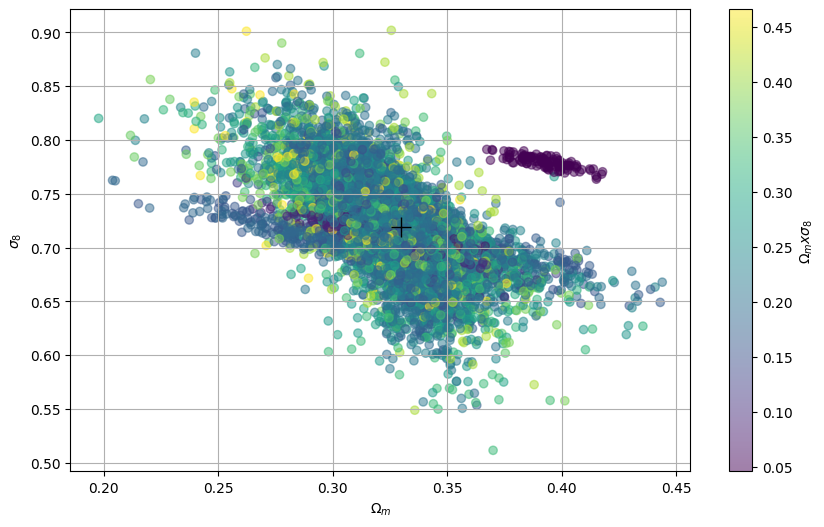

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Lists to store all labels and predictions
all_labels = []
all_predictions = []

# Loop through validation data to create an array for plotting
for batch_x, batch_y in val_gen:
    #print(batch_x, batch_y)
    predictions = modelbig.predict(batch_x)
    all_labels.append(batch_y)
    all_predictions.append(predictions)


# Convert lists to numpy arrays
all_labels = np.concatenate(all_labels, axis=0)
all_predictions = np.concatenate(all_predictions, axis=0)


# Calculate fractional difference
fractional_difference = (all_predictions - all_labels) / (all_labels + 1e-8)  # added small value to avoid division by zero

# Extract fractional differences for each label
fractional_difference_label1 = fractional_difference[:, 0]
fractional_difference_label2 = fractional_difference[:, 1]

# Plot
plt.figure(figsize=(10, 6))
#plt.scatter(all_predictions[:,0] + (np.mean(all_labels[:,0])-all_labels[:,0]), \
#            all_predictions[:,1]+  (np.mean(all_labels[:,1])-all_labels[:,1]), alpha=0.5)


# Assuming all_predictions and all_labels are defined
# Calculate the color values
color_values = all_labels[:,0] * all_labels[:,1]


mean_x = np.mean(all_labels[:,0])
mean_y = np.mean(all_labels[:,1])

skip =1 #only show every skip^th value

# Scatter plot with color coding where I've shifted to ahve the same mean

plt.scatter(all_predictions[::skip,0] + (mean_x - all_labels[::skip,0]),
            all_predictions[::skip,1] + (mean_y - all_labels[::skip,1]),
            alpha=0.5, c=color_values[::skip], cmap='viridis')  # 'viridis' is an example colormap


plt.plot(mean_x, mean_y, marker='+', markersize=15, color='black', linestyle='None')


# Adding a colorbar
plt.colorbar(label='$\Omega_m x \sigma_8$')

# Additional plot settings (optional)

#plt.scatter(fractional_difference_label1, fractional_difference_label2, alpha=0.5)
#plt.title('Fractional Difference Scatter Plot')
plt.xlabel('$\Omega_m$')
plt.ylabel('$\sigma_8$')
plt.grid(True)
plt.show()

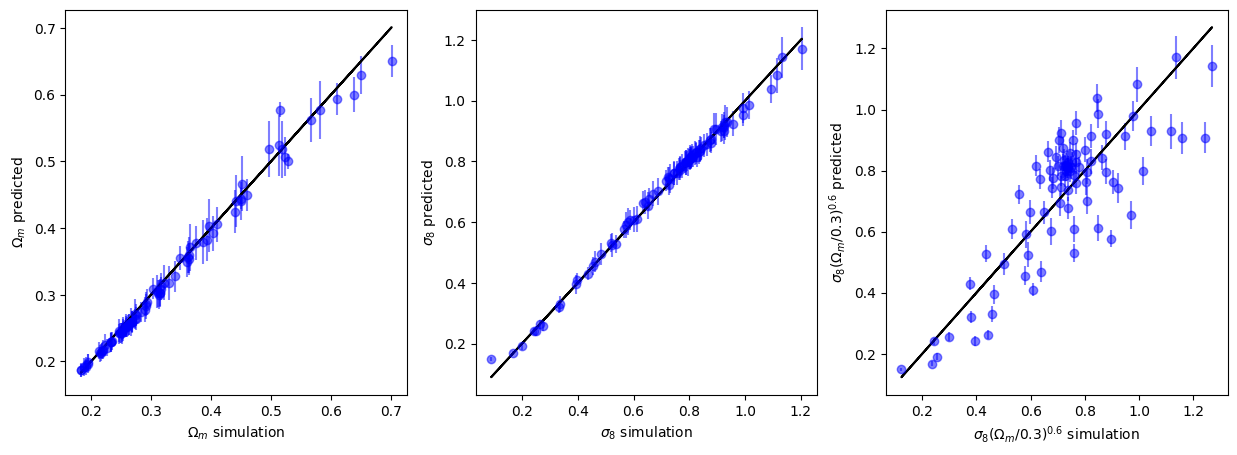

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'all_labels' and 'all_predictions' are defined
# Define 'skip' if needed, or remove '[::skip]'
skip = 1  # or some other integer, depending on your data

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjusted figsize for better visibility

axes[0].set_xlabel('$\Omega_m$ simulation')
axes[0].set_ylabel('$\Omega_m$ predicted')
axes[1].set_xlabel('$\sigma_8$ simulation')
axes[1].set_ylabel('$\sigma_8$ predicted')
axes[2].set_xlabel('$\sigma_8 (\Omega_m/0.3)^{0.6}$ simulation')
axes[2].set_ylabel('$\sigma_8 (\Omega_m/0.3)^{0.6}$ predicted')


plot_mean_only = 1

if plot_mean_only:
    # Group predictions by labels and calculate averages and standard deviations
    predictions_dict = {}
    for label, prediction in zip(all_labels, all_predictions):
        label_tuple = (label[0], label[1])  # Original label tuple
        new_label = label[1] * (label[0] / 0.3)**0.6  # New calculated label
        if label_tuple not in predictions_dict:
            predictions_dict[label_tuple] = {'predictions': [], 'new_labels': []}
        predictions_dict[label_tuple]['predictions'].append(prediction)
        predictions_dict[label_tuple]['new_labels'].append(new_label)

    averaged_predictions = {}
    std_devs = {}
    new_label_values = {}
    for label, data in predictions_dict.items():
        preds_array = np.array(data['predictions'])
        new_labels_array = np.array(data['new_labels'])
        averaged_predictions[label] = np.mean(preds_array, axis=0)
        std_devs[label] = np.std(preds_array, axis=0)
        new_label_values[label] = np.mean(new_labels_array)

    # Plot the averages with error bars
    for label, avg_pred in averaged_predictions.items():
        std_dev = std_devs[label]
        new_label_avg = new_label_values[label]
        axes[0].errorbar(label[0], avg_pred[0], yerr=std_dev[0], fmt='o', color='blue', alpha=0.5)
        axes[1].errorbar(label[1], avg_pred[1], yerr=std_dev[1], fmt='o', color='blue', alpha=0.5)
        axes[2].errorbar(new_label_avg, avg_pred[1], yerr=std_dev[1], fmt='o', color='blue', alpha=0.5)  # New subplot

else:
    axes[0].scatter(all_labels[:, 0], all_predictions[:, 0], alpha=0.5, color='blue')
    axes[1].scatter(all_labels[:, 1], all_predictions[:, 1], alpha=0.5, color='blue')
    axes[2].scatter(all_labels[:, 1] * (all_labels[:, 1] / 0.3)**0.6, all_predictions[:, 1]* (all_predictions[:, 1] / 0.3)**0.6, alpha=0.5, color='blue')

axes[0].plot(all_labels[:, 0], all_labels[:, 0], '-k')
axes[1].plot(all_labels[:, 1], all_labels[:, 1], '-k')
axes[2].plot(all_labels[:, 1] * (all_labels[:, 0] / 0.3)**0.6, all_labels[:, 1] * (all_labels[:, 0] / 0.3)**0.6, '-k')

plt.show()


33/33 [==============================] - 0s 2ms/step


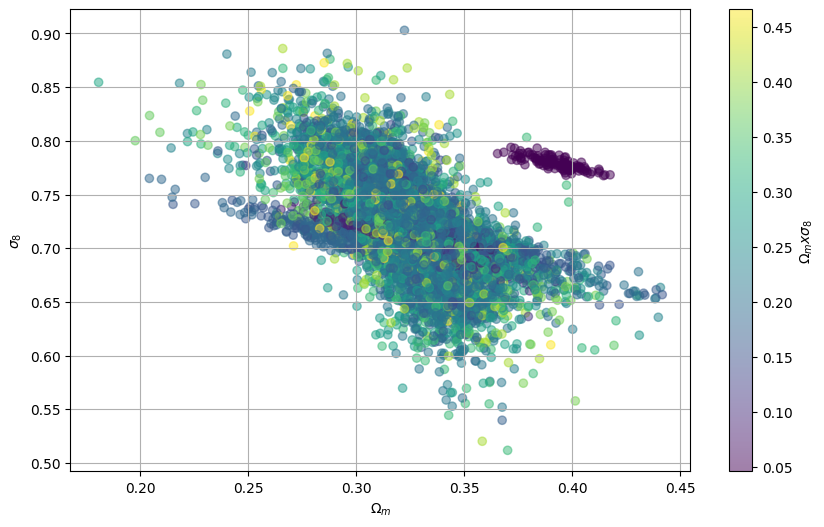

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Lists to store all labels and predictions
all_labels = []
all_predictions = []

# Loop through validation data
for batch_x, batch_y in val_gen:
    #print(batch_x, batch_y)
    predictions = modelbig.predict(batch_x)
    all_labels.append(batch_y)
    all_predictions.append(predictions)

# Convert lists to numpy arrays
all_labels = np.concatenate(all_labels, axis=0)
all_predictions = np.concatenate(all_predictions, axis=0)

# Calculate fractional difference
fractional_difference = (all_predictions - all_labels) / (all_labels + 1e-8)  # added small value to avoid division by zero

# Extract fractional differences for each label
fractional_difference_label1 = fractional_difference[:, 0]
fractional_difference_label2 = fractional_difference[:, 1]

# Plot
plt.figure(figsize=(10, 6))
#plt.scatter(all_predictions[:,0] + (np.mean(all_labels[:,0])-all_labels[:,0]), \
#            all_predictions[:,1]+  (np.mean(all_labels[:,1])-all_labels[:,1]), alpha=0.5)


# Assuming all_predictions and all_labels are defined
# Calculate the color values
color_values = all_labels[:,0] * all_labels[:,1]

# Scatter plot with color coding
plt.scatter(all_predictions[:,0] + (np.mean(all_labels[:,0]) - all_labels[:,0]),
            all_predictions[:,1] + (np.mean(all_labels[:,1]) - all_labels[:,1]),
            alpha=0.5, c=color_values, cmap='viridis')  # 'viridis' is an example colormap

# Adding a colorbar
plt.colorbar(label='$\Omega_m x \sigma_8$')

# Additional plot settings (optional)

#plt.scatter(fractional_difference_label1, fractional_difference_label2, alpha=0.5)
#plt.title('Fractional Difference Scatter Plot')
plt.xlabel('$\Omega_m$')
plt.ylabel('$\sigma_8$')
plt.grid(True)
plt.show()

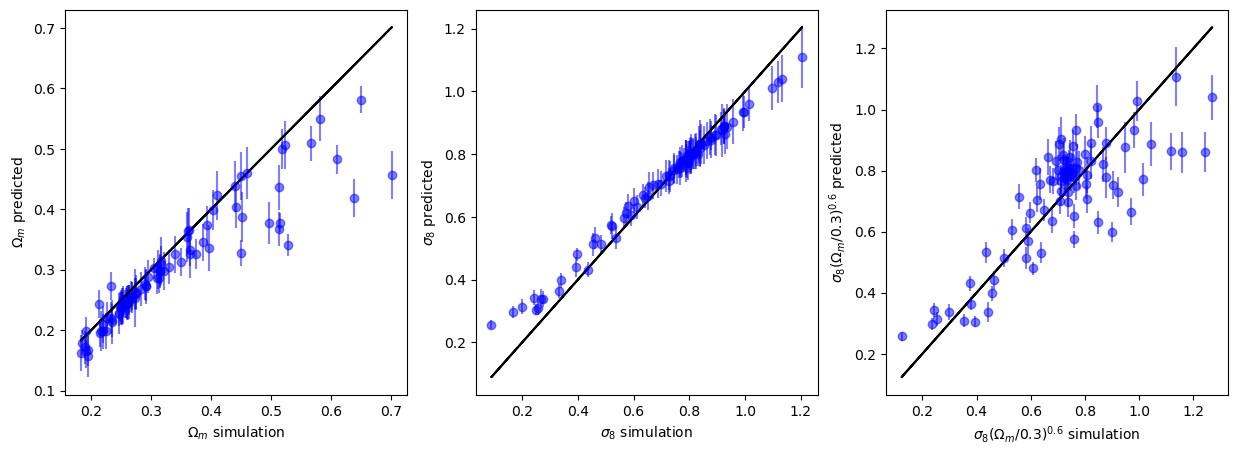

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'all_labels' and 'all_predictions' are defined
# Define 'skip' if needed, or remove '[::skip]'
skip = 1  # or some other integer, depending on your data

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjusted figsize for better visibility

axes[0].set_xlabel('$\Omega_m$ simulation')
axes[0].set_ylabel('$\Omega_m$ predicted')
axes[1].set_xlabel('$\sigma_8$ simulation')
axes[1].set_ylabel('$\sigma_8$ predicted')
axes[2].set_xlabel('$\sigma_8 (\Omega_m/0.3)^{0.6}$ simulation')
axes[2].set_ylabel('$\sigma_8 (\Omega_m/0.3)^{0.6}$ predicted')


plot_mean_only = 1

if plot_mean_only:
    # Group predictions by labels and calculate averages and standard deviations
    predictions_dict = {}
    for label, prediction in zip(all_labels, all_predictions):
        label_tuple = (label[0], label[1])  # Original label tuple
        new_label = label[1] * (label[0] / 0.3)**0.6  # New calculated label
        if label_tuple not in predictions_dict:
            predictions_dict[label_tuple] = {'predictions': [], 'new_labels': []}
        predictions_dict[label_tuple]['predictions'].append(prediction)
        predictions_dict[label_tuple]['new_labels'].append(new_label)

    averaged_predictions = {}
    std_devs = {}
    new_label_values = {}
    for label, data in predictions_dict.items():
        preds_array = np.array(data['predictions'])
        new_labels_array = np.array(data['new_labels'])
        averaged_predictions[label] = np.mean(preds_array, axis=0)
        std_devs[label] = np.std(preds_array, axis=0)
        new_label_values[label] = np.mean(new_labels_array)

    # Plot the averages with error bars
    for label, avg_pred in averaged_predictions.items():
        std_dev = std_devs[label]
        new_label_avg = new_label_values[label]
        axes[0].errorbar(label[0], avg_pred[0], yerr=std_dev[0], fmt='o', color='blue', alpha=0.5)
        axes[1].errorbar(label[1], avg_pred[1], yerr=std_dev[1], fmt='o', color='blue', alpha=0.5)
        axes[2].errorbar(new_label_avg, avg_pred[1], yerr=std_dev[1], fmt='o', color='blue', alpha=0.5)  # New subplot

else:
    axes[0].scatter(all_labels[:, 0], all_predictions[:, 0], alpha=0.5, color='blue')
    axes[1].scatter(all_labels[:, 1], all_predictions[:, 1], alpha=0.5, color='blue')
    axes[2].scatter(all_labels[:, 1] * (all_labels[:, 1] / 0.3)**0.6, all_predictions[:, 1]* (all_predictions[:, 1] / 0.3)**0.6, alpha=0.5, color='blue')

axes[0].plot(all_labels[:, 0], all_labels[:, 0], '-k')
axes[1].plot(all_labels[:, 1], all_labels[:, 1], '-k')
axes[2].plot(all_labels[:, 1] * (all_labels[:, 0] / 0.3)**0.6, all_labels[:, 1] * (all_labels[:, 0] / 0.3)**0.6, '-k')

plt.show()

# Let's take a pre-trained CNN to see if it does better

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Load the ResNet50 model with weights pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(256, activation='relu')(x)  # Dense layer
x = Dense(128, activation='relu')(x)  # Dense layer
x = Dense(64, activation='relu')(x)  # Dense layer
predictions = Dense(2, activation='linear')(x)  # Final dense layer with 2 outputs for your 2 labels

# Construct the full model
modelPreTrained = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
modelPreTrained.compile(optimizer=Adam(learning_rate=learning_rate), loss='mae', metrics=['mae'])

modelPreTrained.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

## The training and validation data sets and the class that generates the batch, which has to be adjusted from above because of the three input channels.

In [ ]:
# Adjust the data generator to repeat the grayscale channel 3 times
class AdjustedWLDataGenerator(WLDataGenerator):
    def __getitem__(self, idx):
        batch_x, batch_y = super().__getitem__(idx)
        batch_x = np.repeat(batch_x, 3, axis=-1)  # Repeat the grayscale channel 3 times

        #to give different weightings that the feature maps can use
        #batch_x_square = np.square(batch_x)
        #batch_x_cube = np.power(batch_x, 3)
        #batch_x = np.concatenate([batch_x, batch_x_square, batch_x_cube], axis=-1)

        #print(np.shape())
        return batch_x, batch_y


# Create adjusted data generators
train_gen_adjusted = AdjustedWLDataGenerator(WL_tensor[:, :training_data_size_sc, :, :], WL_labels[:, :training_data_size_sc, :], batch_size_sc)
val_gen_adjusted = AdjustedWLDataGenerator(WL_tensor[:, training_data_size_sc:training_data_size_sc+validation_data_size_sc, :, :], \
                                           WL_labels[:, training_data_size_sc:training_data_size_sc+validation_data_size_sc, :], batch_size_sc)


## Now let's train

In [ ]:

# Train the model using the adjusted data generators
modelPreTrained.fit(train_gen_adjusted, validation_data=val_gen_adjusted, epochs=40,  callbacks=[reduce_lr])

Epoch 1/40
10/10 [==============================] - 66s 6s/step - loss: 0.2585 - mae: 0.2585 - val_loss: 0.0934 - val_mae: 0.0934 - lr: 0.0010
Epoch 2/40
10/10 [==============================] - 58s 6s/step - loss: 0.0734 - mae: 0.0734 - val_loss: 0.0606 - val_mae: 0.0606 - lr: 0.0010
Epoch 3/40
10/10 [==============================] - 58s 6s/step - loss: 0.0531 - mae: 0.0531 - val_loss: 0.0477 - val_mae: 0.0477 - lr: 0.0010
Epoch 4/40
10/10 [==============================] - 57s 6s/step - loss: 0.0465 - mae: 0.0465 - val_loss: 0.0477 - val_mae: 0.0477 - lr: 0.0010
Epoch 5/40
10/10 [==============================] - 59s 6s/step - loss: 0.0477 - mae: 0.0477 - val_loss: 0.0483 - val_mae: 0.0483 - lr: 0.0010
Epoch 6/40
10/10 [==============================] - 59s 6s/step - loss: 0.0445 - mae: 0.0445 - val_loss: 0.0413 - val_mae: 0.0413 - lr: 0.0010
Epoch 7/40
10/10 [==============================] - 58s 6s/step - loss: 0.0420 - mae: 0.0420 - val_loss: 0.0402 - val_mae: 0.0402 - lr: 0.0010

In [ ]:
for layer in base_model.layers[-5:]: #train last five layers, including some resnet layers
    layer.trainable = True

# Re-compile the model after making layer adjustments
# It's important to re-compile the model after you unfreeze the layers
modelPreTrained.compile(optimizer=Adam(learning_rate=learning_rate),  # You might want to use a lower learning rate for fine-tuning
                        loss='mae',
                        metrics=['mae'])

modelPreTrained.fit(train_gen_adjusted, validation_data=val_gen_adjusted, epochs=40,  callbacks=[reduce_lr])

#Same pretrained model but with residual connections

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 model with weights pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer

# First dense block with residual connection
x1 = Dense(256, activation='relu')(x)
x = Dense(256, activation='linear')(x1)
x = Add()([x, x1])
x = tf.keras.layers.ReLU()(x)

# Second dense block with residual connection
x2 = Dense(128, activation='relu')(x)
x = Dense(128, activation='linear')(x2)
x = Add()([x, x2])
x = tf.keras.layers.ReLU()(x)

# Third dense block with residual connection
x3 = Dense(64, activation='relu')(x)
x = Dense(64, activation='linear')(x3)
x = Add()([x, x3])
x = tf.keras.layers.ReLU()(x)

predictions = Dense(2, activation='linear')(x)  # Final dense layer with 2 outputs for your 2 labels

# Construct the full model
# Construct the full model
modelPreTrained = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
modelPreTrainedResCon.compile(optimizer=Adam(learning_rate=learning_rate), loss='mae', metrics=['mae'])

modelPreTrained.summary()

In [ ]:
modelPreTrainedResCon.fit(train_gen_adjusted, validation_data=val_gen_adjusted, epochs=40,  callbacks=[reduce_lr])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Lists to store all labels and predictions
all_labels = []
all_predictions = []

# Loop through validation data
for batch_x, batch_y in val_gen:
    #print(batch_x, batch_y)
    predictions = modelPreTrained.predict(batch_x)
    all_labels.append(batch_y)
    all_predictions.append(predictions)

# Convert lists to numpy arrays
all_labels = np.concatenate(all_labels, axis=0)
all_predictions = np.concatenate(all_predictions, axis=0)

# Calculate fractional difference
fractional_difference = (all_predictions - all_labels) / (all_labels + 1e-8)  # added small value to avoid division by zero

# Extract fractional differences for each label
fractional_difference_label1 = fractional_difference[:, 0]
fractional_difference_label2 = fractional_difference[:, 1]

# Plot
plt.figure(figsize=(10, 6))
#plt.scatter(all_predictions[:,0] + (np.mean(all_labels[:,0])-all_labels[:,0]), \
#            all_predictions[:,1]+  (np.mean(all_labels[:,1])-all_labels[:,1]), alpha=0.5)


# Assuming all_predictions and all_labels are defined
# Calculate the color values
color_values = all_labels[:,0] * all_labels[:,1]

# Scatter plot with color coding
plt.scatter(all_predictions[:,0] + (np.mean(all_labels[:,0]) - all_labels[:,0]),
            all_predictions[:,1] + (np.mean(all_labels[:,1]) - all_labels[:,1]),
            alpha=0.5, c=color_values, cmap='viridis')  # 'viridis' is an example colormap

# Adding a colorbar
plt.colorbar(label='$\Omega_m \times \sigma_8$')

# Additional plot settings (optional)

#plt.scatter(fractional_difference_label1, fractional_difference_label2, alpha=0.5)
#plt.title('Fractional Difference Scatter Plot')
plt.xlabel('$\Omega_m$')
plt.ylabel('$\sigma_8$')
plt.grid(True)
plt.show()

# Attempt to visualize output of CNN

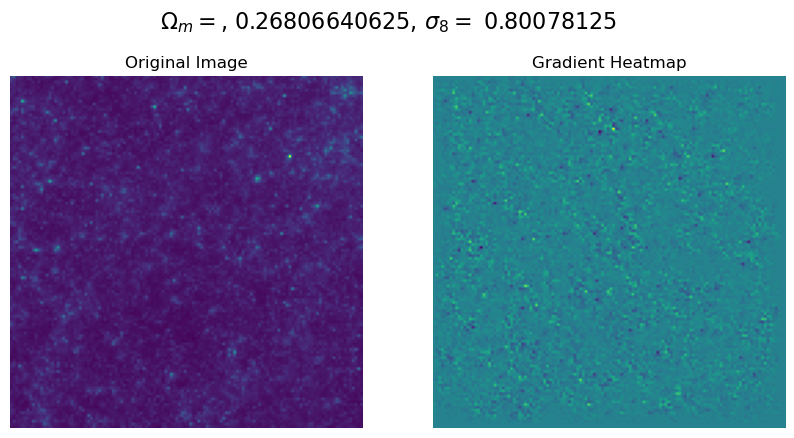

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Select an image for visualization
idx, idy = 0, 0  # Replace with desired indices
original_img= WL_tensor[idx, idy, :, :]
img_array = tf.expand_dims(original_img, axis=-1)  # Add channel dimension if needed
img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension


output_index = 0  # Choose which output to visualize

with tf.GradientTape() as tape:
    tape.watch(img_array)
    predictions = model(img_array)
    output_to_visualize = predictions[:, output_index]

grads = tape.gradient(output_to_visualize, img_array)
grads = tf.reduce_mean(grads, axis=-1)
grads = grads[0]  # Rem


# Normalize the gradients
grads -= tf.reduce_min(grads)
grads /= tf.reduce_max(grads)

# Convert to numpy array for visualization
grads = grads.numpy()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

original_img = (original_img - np.min(original_img)) / (np.max(original_img) - np.min(original_img))  # Rescale to [0, 1]
# Plot the original image
axes[0].imshow(original_img, cmap='viridis')  # Assuming the original image is grayscale
axes[0].axis('off')
axes[0].set_title('Original Image')

# Plot the gradient heatmap
axes[1].imshow(grads, cmap='viridis')
axes[1].axis('off')
axes[1].set_title('Gradient Heatmap')

fig.suptitle(f' $\Omega_m =$, {WL_labels[idx, idy, 0]}, $\sigma_8=$ {WL_labels[idx, idy, 1]}', fontsize=16)


plt.show()